# `TauModel` Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate the basic features of the `TauModel` model. `TauModel` models the 1612, 1665, 1667, and 1720 MHz hyperfine transitions of OH and predicts their optical depth spectra.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import amoeba2
print("amoeba2 version:", amoeba2.__version__)

from amoeba2 import TauModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.6.2+0.g883013c.dirty
amoeba2 version: 1.0.0-staging+0.g61de2dc.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `TauModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"tau_1612", "tau_1665", "tau_1667", and "tau_1720"`.

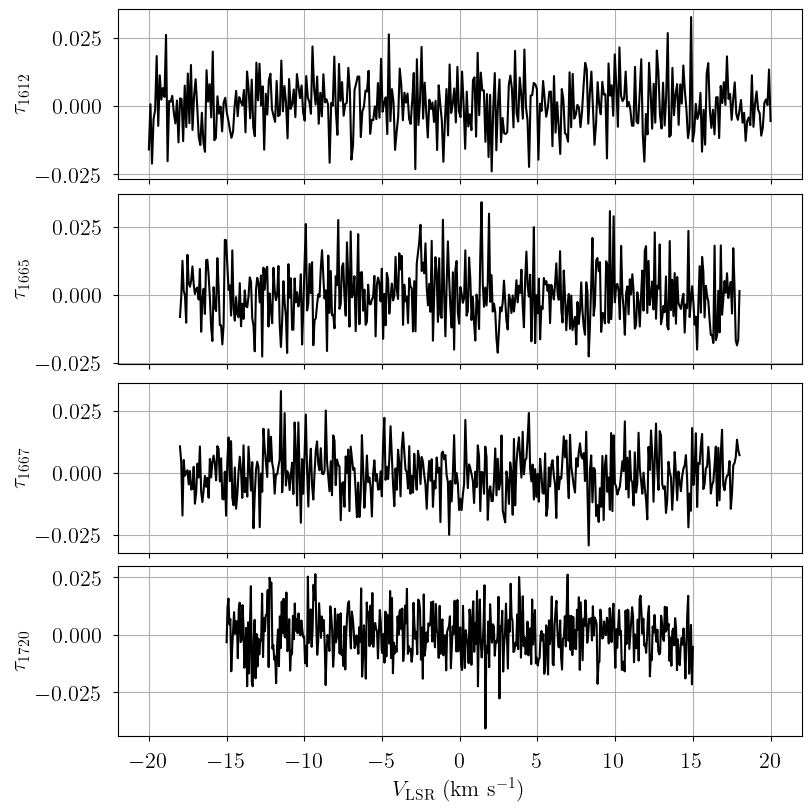

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = {
    "1612": np.linspace(-20.0, 20.0, 400), # km s-1
    "1665": np.linspace(-18.0, 18.0, 450),
    "1667": np.linspace(-18.0, 18.0, 450),
    "1720": np.linspace(-15.0, 15.0, 500),
}

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_tau = {
    "1612": 0.01,
    "1665": 0.01,
    "1667": 0.01,
    "1720": 0.01,
}

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
tau = {label: rms_tau[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}

# TauModel expects four observations
dummy_data = {
    f"tau_{label}": SpecData(
        velo_axis[label],
        tau[label],
        rms_tau[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau_{"+f"{label}"+r"}$"
    )
    for label in velo_axis.keys()
}

# Plot dummy data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for ax, dummy_datum in zip(axes, dummy_data.values()):
    ax.plot(dummy_datum.spectral, dummy_datum.brightness, "k-")
    ax.set_ylabel(dummy_datum.ylabel)
_ = axes[-1].set_xlabel(dummy_datum.xlabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = TauModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.0, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [0.0, 10.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.1, # width of optical depth rms prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

In [5]:
# Evaluate likelihood for given model parameters
# excitation temperature for 1612, 1665, and 1667 MHz
inv_Tex_free = np.array([
    [0.2, -0.2, 0.06], # cloud 0
    [0.06, 0.1, 0.2], # cloud 1
    [0.06, 0.06, 0.1] # cloud 2
])

sim_params = {
    "log10_N_0": np.array([14.0, 14.5, 13.5]),
    "inv_Tex_free": inv_Tex_free,
    "fwhm": np.array([1.2, 1.5, 0.8]),
    "velocity": np.array([-3.0, 1.0, 3.0]),
    "rms_tau": np.array([0.01, 0.008, 0.012, 0.01]),
}

data = {}
for i, label in enumerate(velo_axis.keys()):
    sim_params_label = sim_params.copy()
    sim_params_label[f"baseline_tau_{label}_norm"] = np.array([0.0, -1.0, 2.0])
    tau = model.model[f"tau_{label}"].eval(sim_params_label)
    data[f"tau_{label}"] = SpecData(
        velo_axis[label],
        tau,
        sim_params["rms_tau"][i],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau_{"+f"{label}"+r"}$"
    )

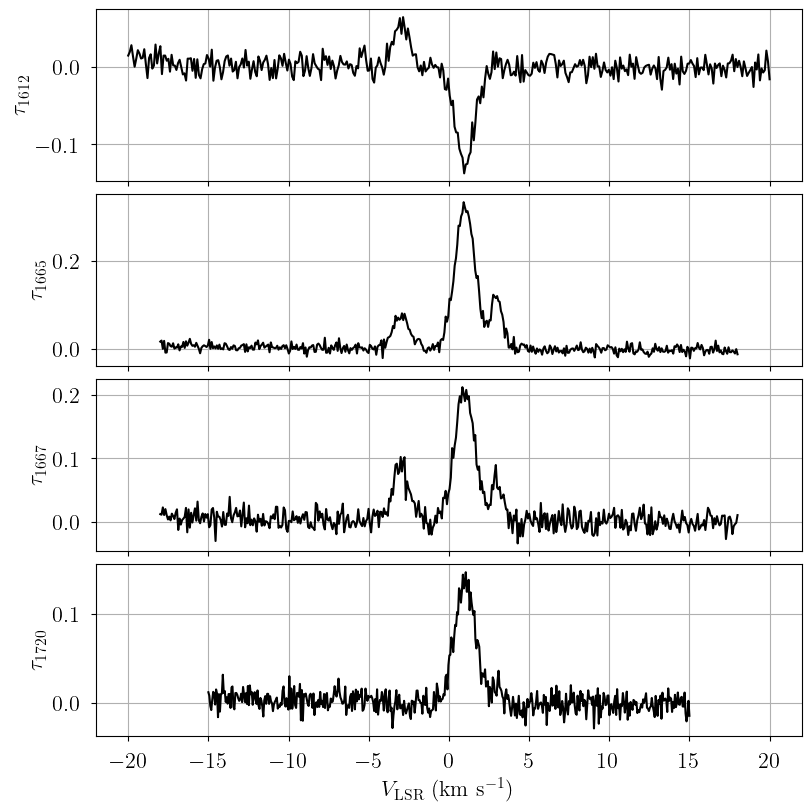

In [6]:
# Plot data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for ax, datum in zip(axes, data.values()):
    ax.plot(datum.spectral, datum.brightness, "k-")
    ax.set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `TauModel`. Here we create a new model with the simulated data.

In [7]:
# Initialize and define the model
model = TauModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.0, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [0.0, 1.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.1, # width of optical depth rms prior (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

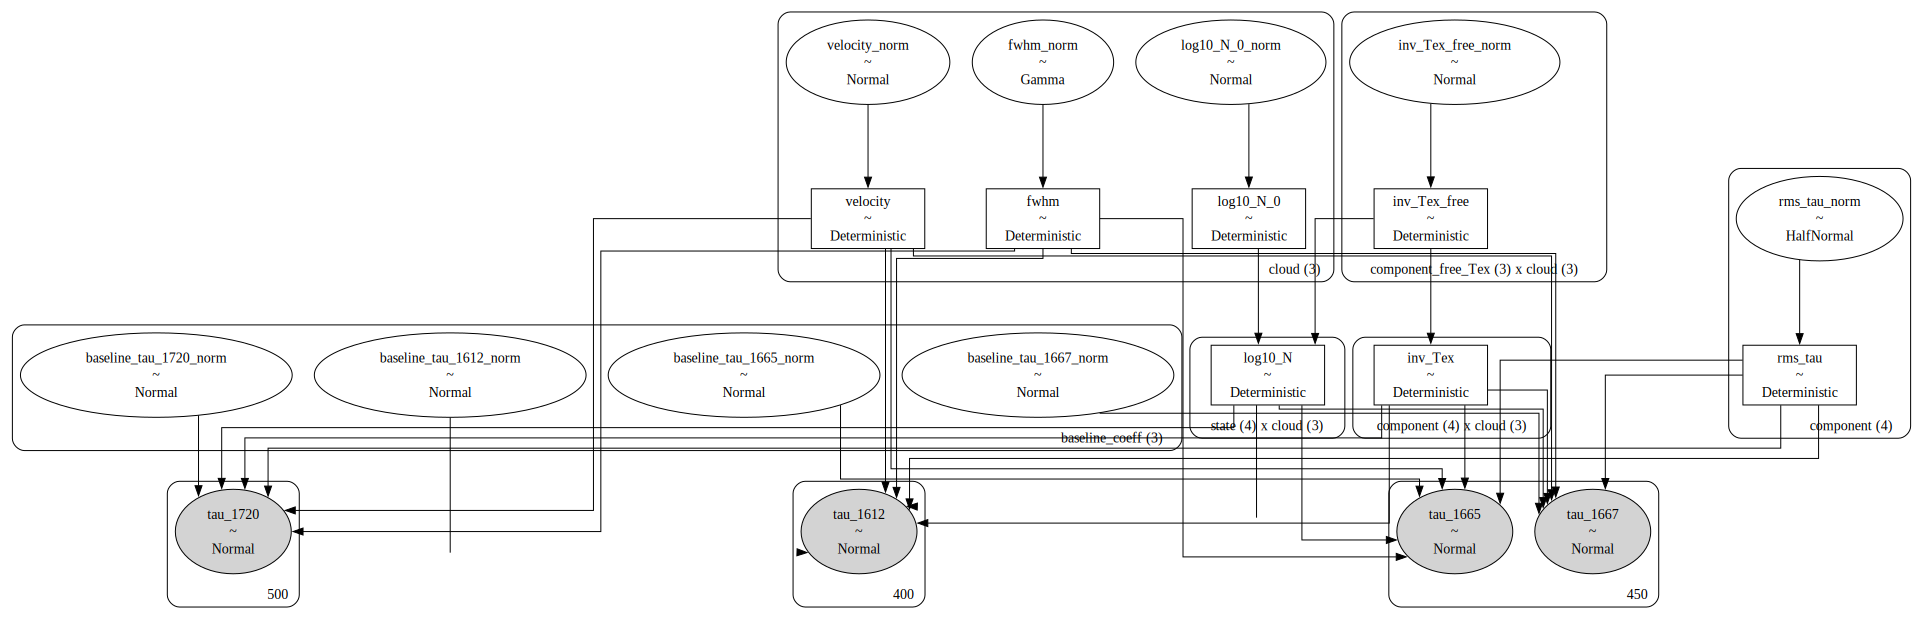

In [89]:
# Plot model graph
gviz = pm.model_to_graphviz(model.model)
gviz.graph_attr["rankdir"] = "TB"
gviz.graph_attr["splines"] = "ortho"
# gviz.graph_attr["newrank"] = "true"
gviz.graph_attr["rank"] = "same"
gviz.graph_attr["ranksep"] = "1.0"
gviz.graph_attr["nodesep"] = "0.3"
gviz.render('tau_model', format='png')
gviz

In [90]:
# model string representation
print(model.model.str_repr())

baseline_tau_1612_norm ~ Normal(0, <constant>)
baseline_tau_1665_norm ~ Normal(0, <constant>)
baseline_tau_1667_norm ~ Normal(0, <constant>)
baseline_tau_1720_norm ~ Normal(0, <constant>)
        log10_N_0_norm ~ Normal(0, 1)
     inv_Tex_free_norm ~ Normal(0, 1)
             fwhm_norm ~ Gamma(2, f())
         velocity_norm ~ Normal(0, 1)
          rms_tau_norm ~ HalfNormal(0, 1)
             log10_N_0 ~ Deterministic(f(log10_N_0_norm))
          inv_Tex_free ~ Deterministic(f(inv_Tex_free_norm))
               inv_Tex ~ Deterministic(f(inv_Tex_free_norm))
               log10_N ~ Deterministic(f(log10_N_0_norm, inv_Tex_free_norm))
                  fwhm ~ Deterministic(f(fwhm_norm))
              velocity ~ Deterministic(f(velocity_norm))
               rms_tau ~ Deterministic(f(rms_tau_norm))
              tau_1612 ~ Normal(f(baseline_tau_1612_norm, log10_N_0_norm, fwhm_norm, velocity_norm, inv_Tex_free_norm), f(rms_tau_norm))
              tau_1665 ~ Normal(f(baseline_tau_1665_norm,

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [baseline_tau_1612_norm, baseline_tau_1665_norm, baseline_tau_1667_norm, baseline_tau_1720_norm, fwhm_norm, inv_Tex_free_norm, log10_N_0_norm, rms_tau_norm, tau_1612, tau_1665, tau_1667, tau_1720, velocity_norm]


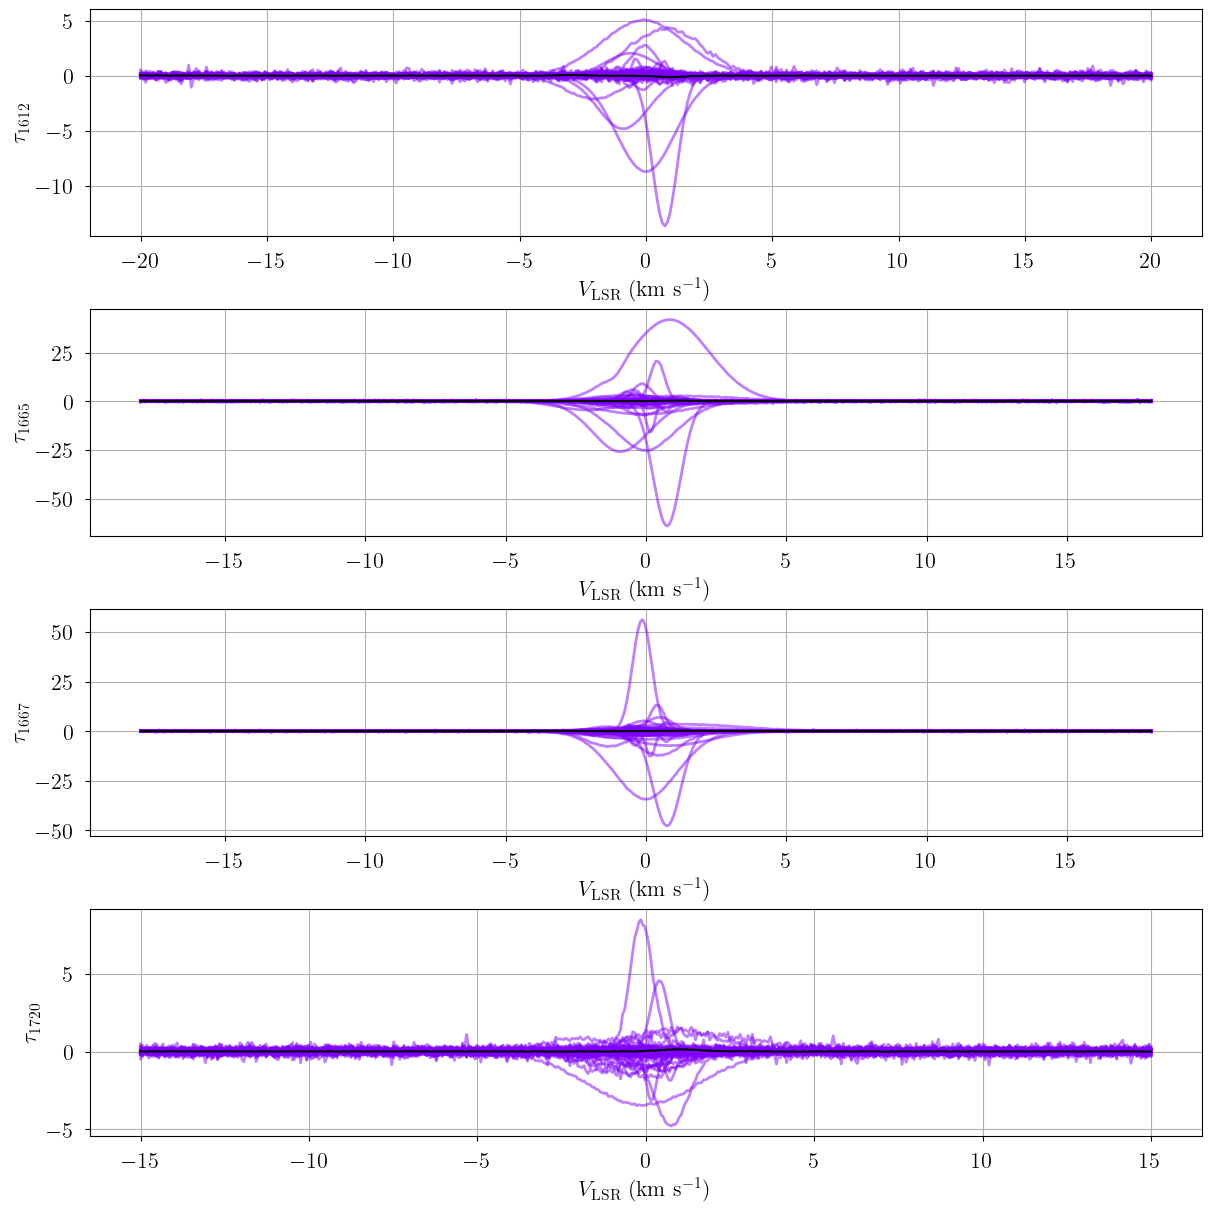

In [99]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
axes = plot_predictive(model.data, prior.prior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [100]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 6600
Interrupted at 6,599 [6%]: Average Loss = -4,597


Runtime: 1.61 minutes


In [101]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_tau_1612_norm[0],0.065,0.024,0.019,0.104,0.001,0.001,768.0,821.0,NaN
baseline_tau_1612_norm[1],-0.351,0.078,-0.506,-0.207,0.003,0.002,957.0,1028.0,NaN
baseline_tau_1612_norm[2],1.238,0.433,0.392,2.037,0.014,0.010,964.0,901.0,NaN
baseline_tau_1665_norm[0],-0.351,0.008,-0.366,-0.337,0.000,0.000,1010.0,898.0,NaN
baseline_tau_1665_norm[1],-0.174,0.026,-0.223,-0.127,0.001,0.001,961.0,986.0,NaN
baseline_tau_1665_norm[2],0.316,0.146,0.064,0.608,0.005,0.004,799.0,694.0,NaN
baseline_tau_1667_norm[0],-0.368,0.015,-0.396,-0.339,0.000,0.000,957.0,838.0,NaN
baseline_tau_1667_norm[1],-0.192,0.055,-0.297,-0.087,0.002,0.001,1082.0,939.0,NaN
baseline_tau_1667_norm[2],0.624,0.318,0.023,1.225,0.011,0.008,789.0,948.0,NaN
baseline_tau_1720_norm[0],-0.315,0.018,-0.351,-0.285,0.001,0.000,986.0,942.0,NaN


Sampling: [tau_1612, tau_1665, tau_1667, tau_1720]


Output()

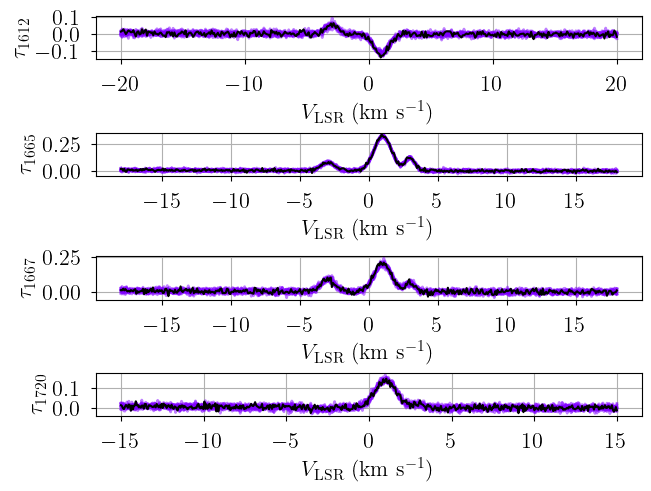

In [102]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC. Due to the strong degeneracy between column density and excitation temperature in this optical depth-only model, we have to increase the number of tuning samples (`tune`) and the NUTS acceptance rate `target_accept` for efficient sampling.

In [103]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 2000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6600
Interrupted at 6,599 [6%]: Average Loss = -4,597
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_tau_1612_norm, baseline_tau_1665_norm, baseline_tau_1667_norm, baseline_tau_1720_norm, log10_N_0_norm, inv_Tex_free_norm, fwhm_norm, velocity_norm, rms_tau_norm]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 946 seconds.


There were 83 divergences in converged chains.
Runtime: 16.85 minutes


In [104]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1!

In [105]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_tau_1612_norm[0],0.087,0.032,0.029,0.150,0.001,0.000,3061.0,2860.0,1.00
baseline_tau_1612_norm[1],-0.348,0.071,-0.472,-0.208,0.001,0.001,5505.0,2797.0,1.00
baseline_tau_1612_norm[2],0.906,0.556,-0.143,1.962,0.010,0.007,3204.0,3082.0,1.00
baseline_tau_1665_norm[0],-0.355,0.013,-0.379,-0.332,0.000,0.000,2941.0,3024.0,1.00
baseline_tau_1665_norm[1],-0.170,0.024,-0.213,-0.125,0.000,0.000,5641.0,2821.0,1.00
baseline_tau_1665_norm[2],0.331,0.224,-0.089,0.751,0.004,0.003,3045.0,3043.0,1.00
baseline_tau_1667_norm[0],-0.372,0.025,-0.420,-0.328,0.000,0.000,3492.0,2773.0,1.00
baseline_tau_1667_norm[1],-0.200,0.051,-0.299,-0.108,0.001,0.000,5685.0,2619.0,1.00
baseline_tau_1667_norm[2],0.646,0.441,-0.137,1.514,0.008,0.006,3361.0,2766.0,1.00
baseline_tau_1720_norm[0],-0.293,0.025,-0.337,-0.245,0.000,0.000,2865.0,2912.0,1.00


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [tau_1612, tau_1665, tau_1667, tau_1720]


Output()

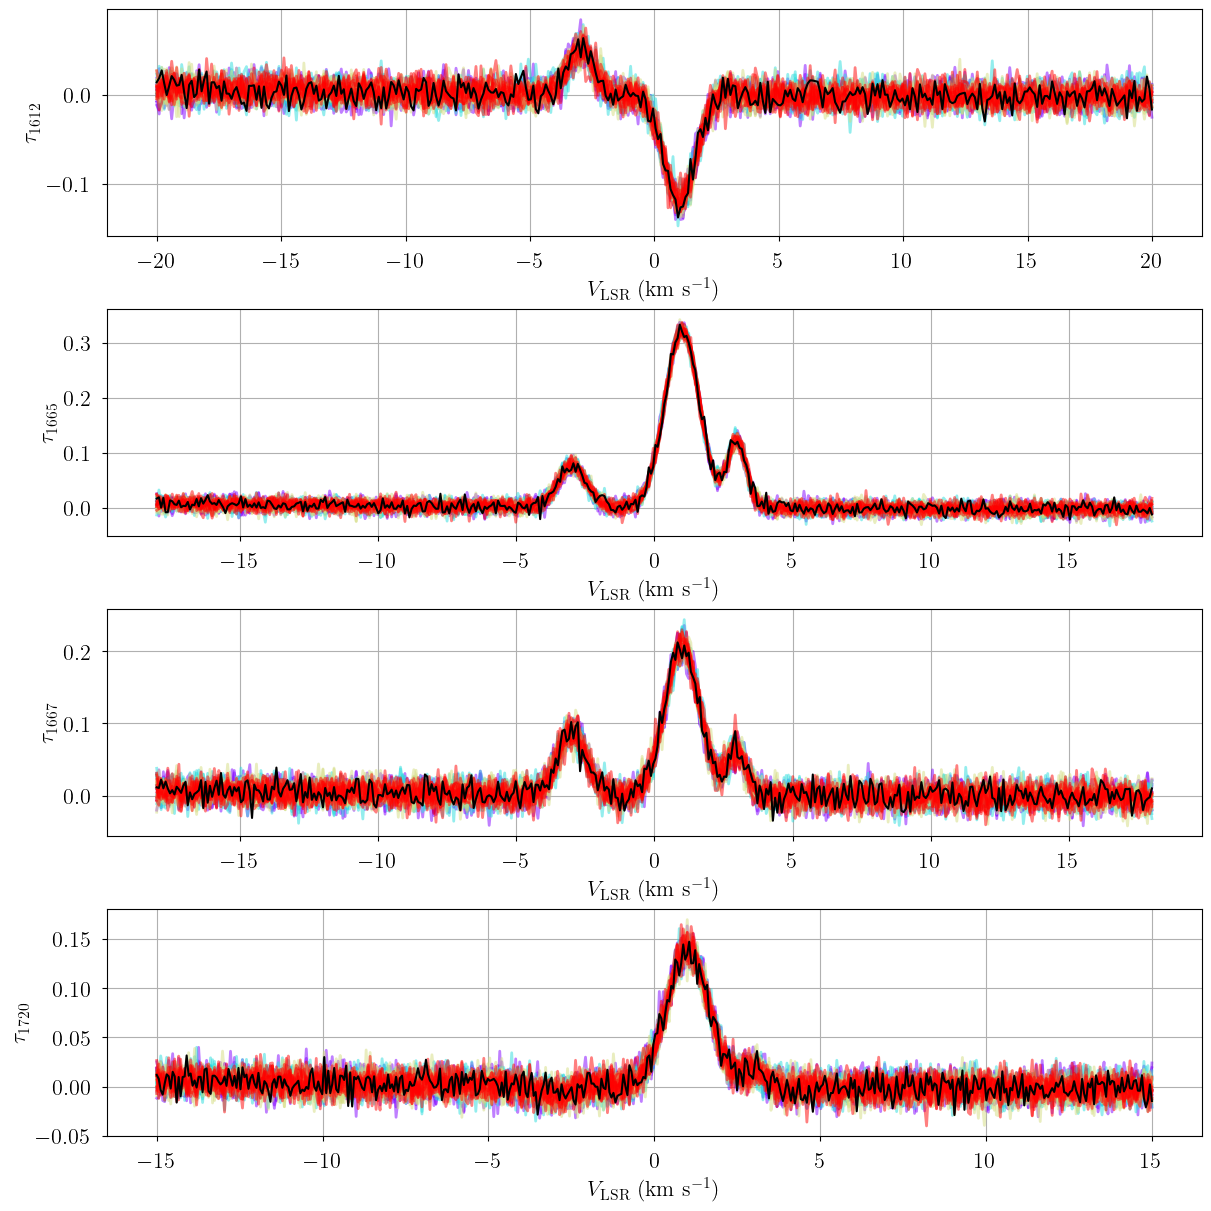

In [107]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

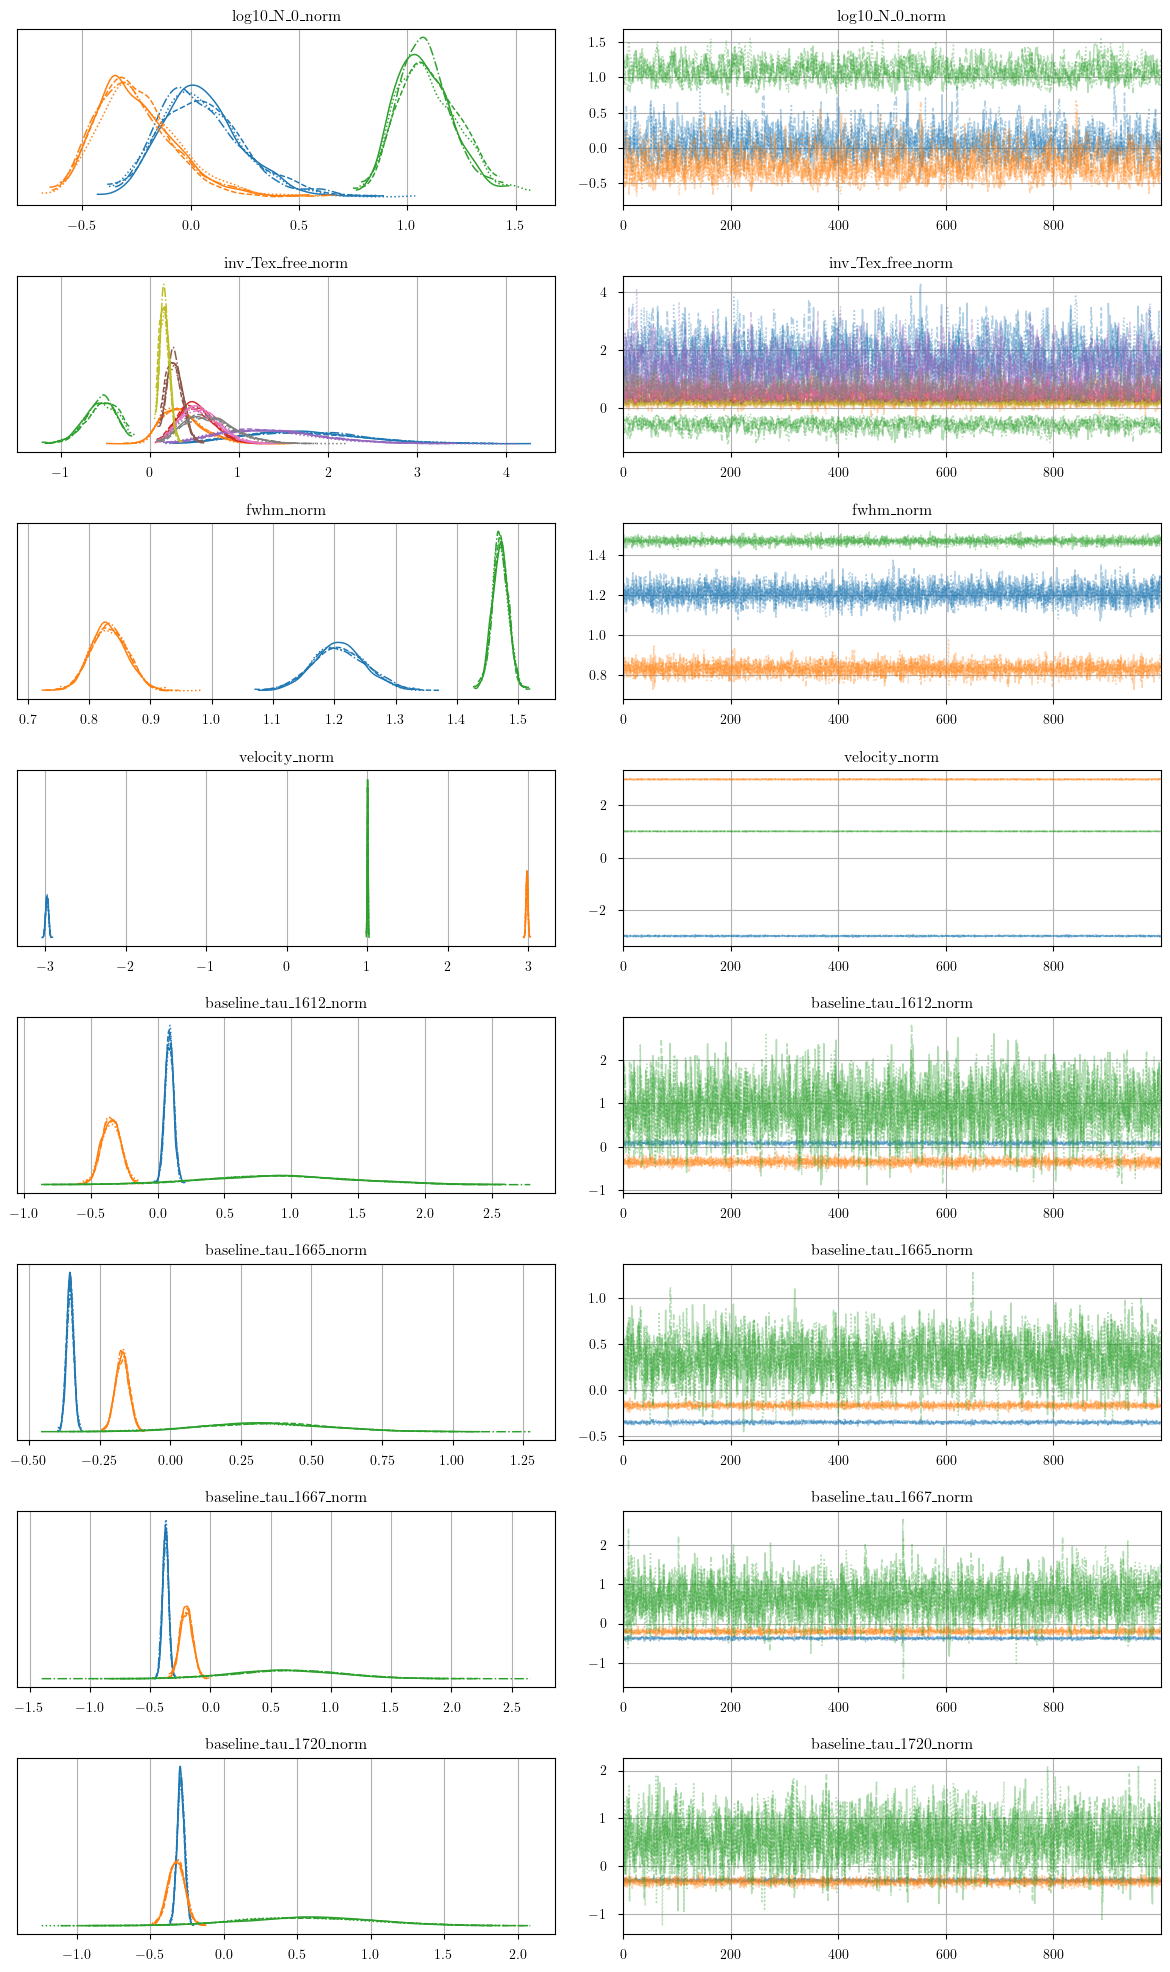

In [111]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
axes.ravel()[0].figure.set_size_inches(12, 20)
axes.ravel()[0].figure.tight_layout()

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

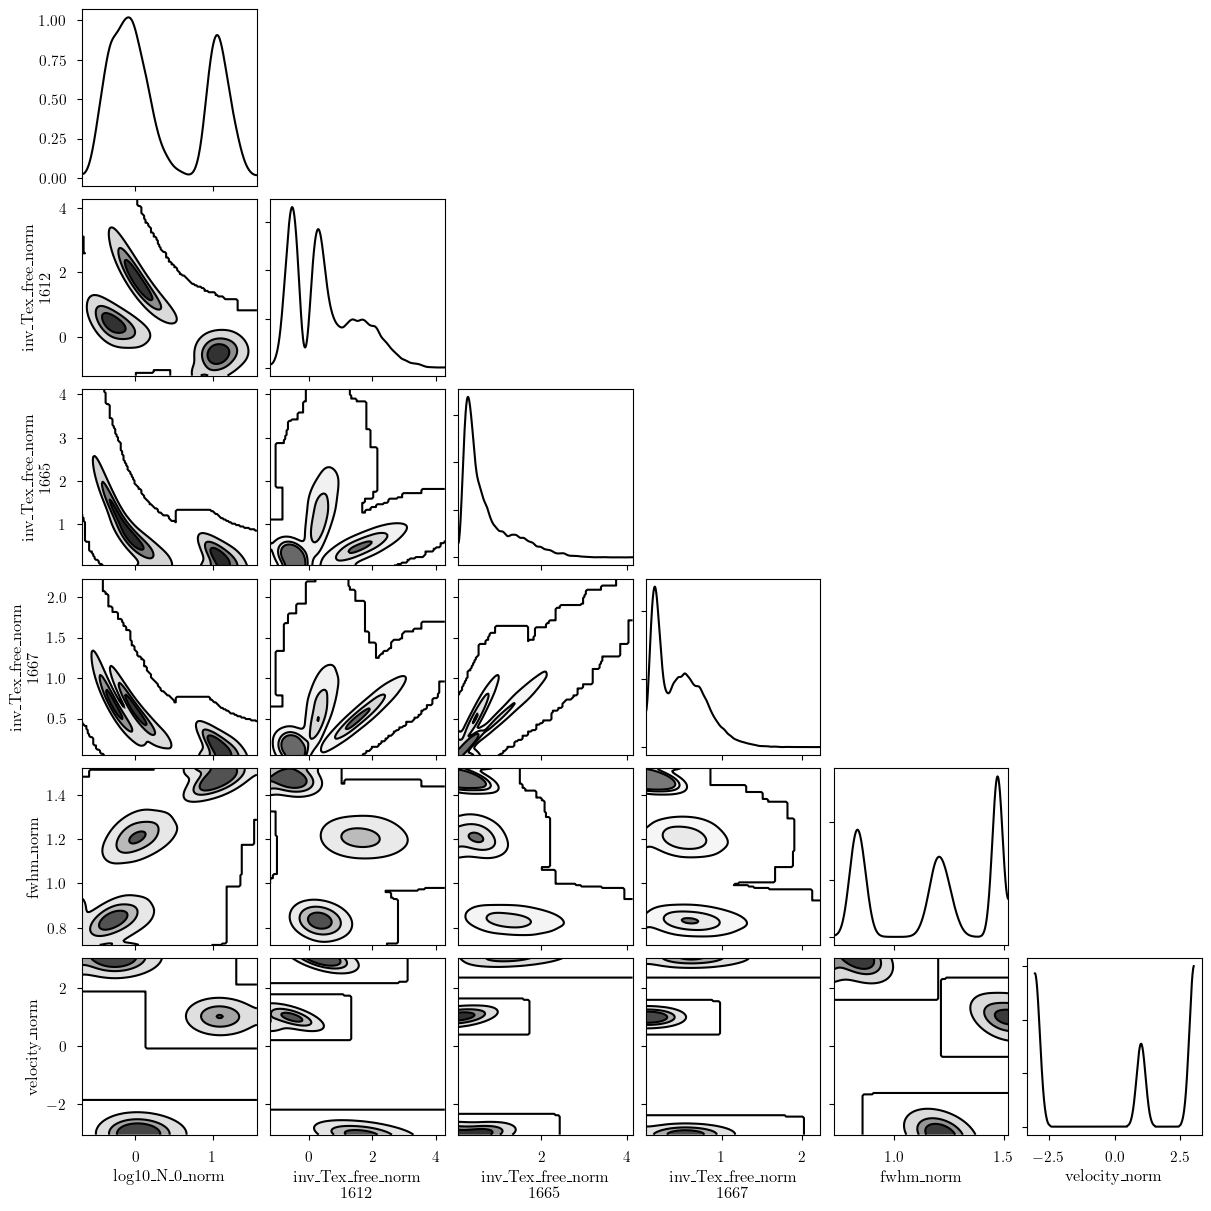

In [113]:
from bayes_spec.plots import plot_pair

axes = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(12, 12)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud. Also notice the tight correlation between column density and excitation temperature: optical depth spectra alone struggle to break this degeneracy!

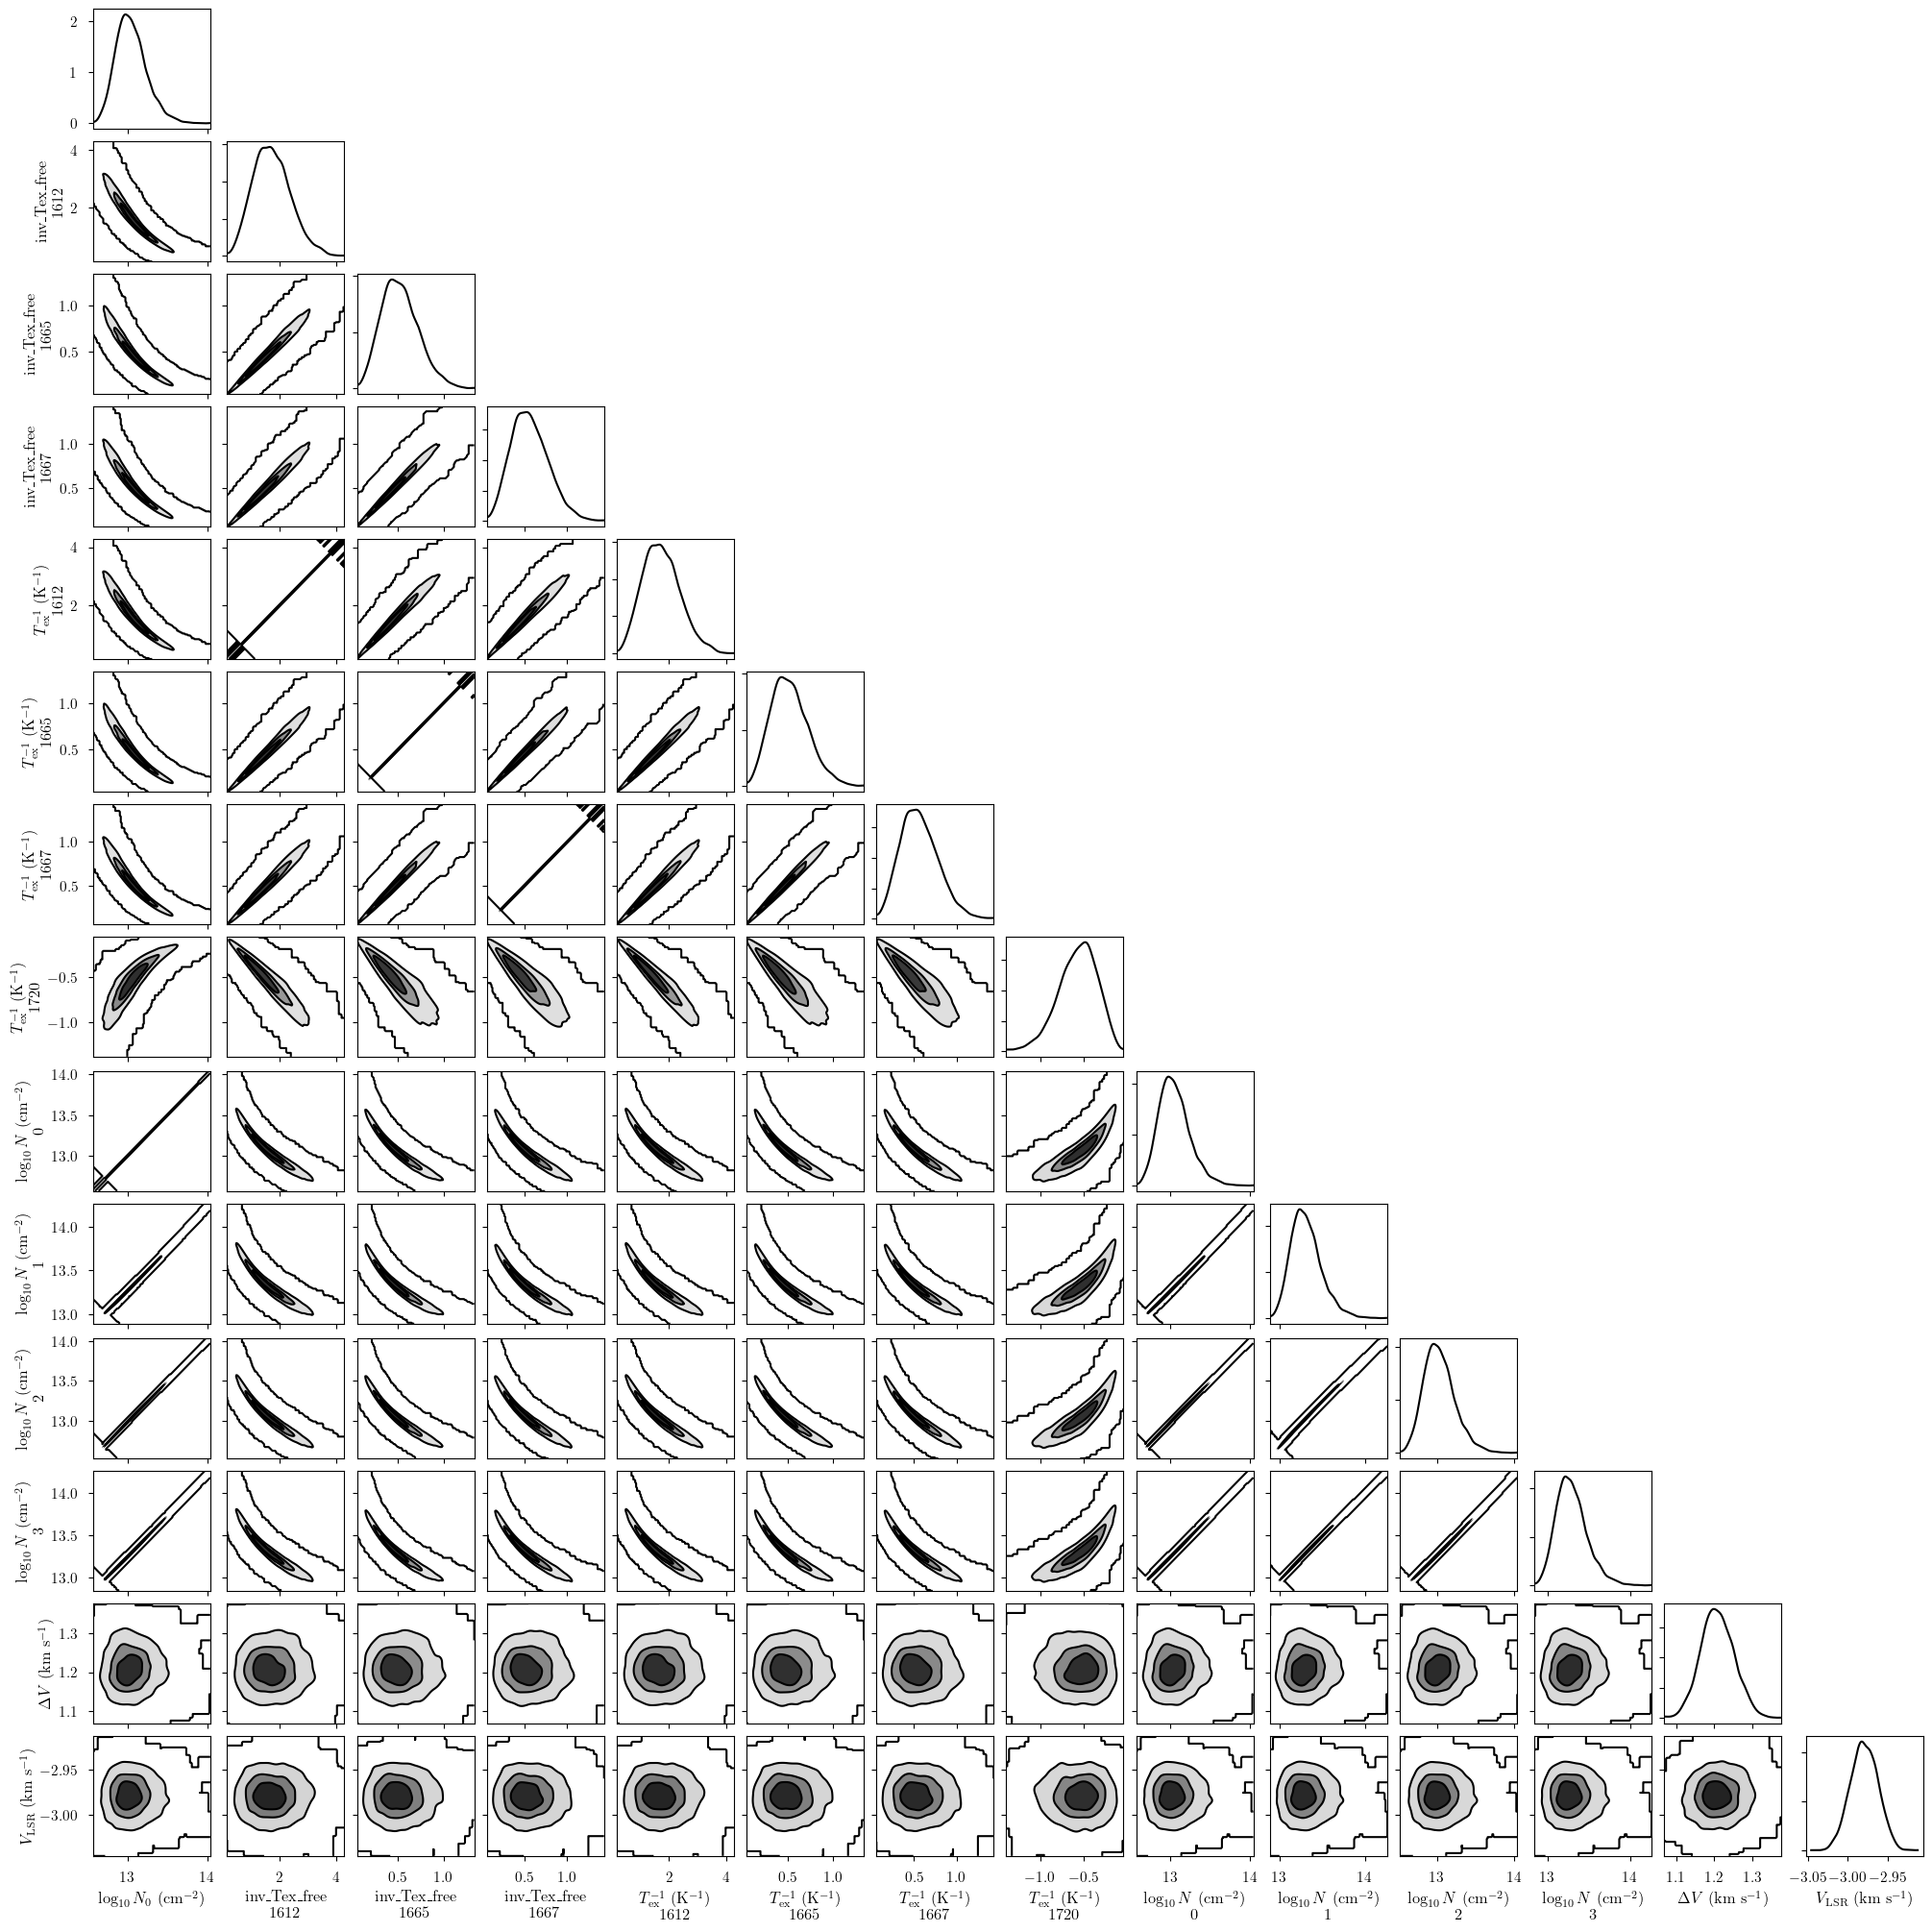

In [116]:
axes = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(20, 20)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [117]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -11095.328708050263


,mean,sd,hdi_16%,hdi_84%
baseline_tau_1612_norm[0],0.087,0.032,0.059,0.122
baseline_tau_1612_norm[1],-0.348,0.071,-0.429,-0.286
baseline_tau_1612_norm[2],0.906,0.556,0.353,1.455
baseline_tau_1665_norm[0],-0.355,0.013,-0.368,-0.343
baseline_tau_1665_norm[1],-0.170,0.024,-0.194,-0.147
baseline_tau_1665_norm[2],0.331,0.224,0.099,0.539
baseline_tau_1667_norm[0],-0.372,0.025,-0.396,-0.348
baseline_tau_1667_norm[1],-0.200,0.051,-0.255,-0.154
baseline_tau_1667_norm[2],0.646,0.441,0.234,1.097
baseline_tau_1720_norm[0],-0.293,0.025,-0.321,-0.271
